Results Analysis and Algorithmic Decisions

### Overview

In this work, we implemented three approaches to solve the **Traveling Salesman Problem (TSP)**: the Greedy algorithm, the Simulated Annealing and the Genetic Algorithm. Each method has unique characteristics that influence the results and performance. Below are the results obtained and the motivations behind the algorithmic choices made.

In [103]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import random

def load_and_distance_matrix(file_name):
    """Loads city data from CSV and calculates the distance matrix."""
    cities = pd.read_csv(file_name, header=None, names=['name', 'lat', 'lon'])
    n_cities = len(cities)
    distance_matrix = np.zeros((n_cities, n_cities))
    
    for c1, c2 in combinations(cities.itertuples(), 2):
        distance_matrix[c1.Index, c2.Index] = distance_matrix[c2.Index, c1.Index] = geodesic(
            (c1.lat, c1.lon), (c2.lat, c2.lon)
        ).km
    
    return distance_matrix, cities, n_cities




1. Greedy Algorithm

The Greedy algorithm, or "nearest neighbor" approach, constructs a solution by choosing the closest node at each step, without ever going back. This method is effective at quickly producing a complete path, although it does not guarantee the overall optimality of the resulting path.

- **Result**: The path obtained with the Greedy algorithm is often longer than the solutions produced by other algorithms. However, it provides a quick and approximate starting point that can be further optimized.
- **Algorithmic Choice**: The Greedy algorithm was selected as a starting point due to its simplicity and speed of execution. Although it tends to generate a suboptimal path due to its "short-sighted" nature, its speed makes it ideal as a starting solution. This path can then be used as input to more complex algorithms, such as Simulated Annealing, which aim to optimize the solution.

In [104]:
def greedy_algorithm(distance_matrix, start_city=0):
    """Finds a path using the greedy (nearest neighbor) algorithm."""
    n_cities = len(distance_matrix)
    visited = np.full(n_cities, False)
    path = [start_city]
    visited[start_city] = True
    
    while len(path) < n_cities:
        last_city = path[-1]
        # Find the nearest unvisited city
        closest_city = np.argmin([distance_matrix[last_city, j] if not visited[j] else np.inf for j in range(n_cities)])
        path.append(closest_city)
        visited[closest_city] = True

    path.append(start_city)  # Close the loop
    total_cost = calculate_total_distance(path, distance_matrix)
    
    return path, total_cost


2. Simulated Annealing

Simulated Annealing is a metaheuristic optimization technique that mimics the cooling process in metals. It allows the system to occasionally accept worse solutions to avoid being confined to local minima, gradually reducing the probability of accepting such solutions as the "temperature" of the system decreases.

- **Result**: Compared to the Greedy algorithm, Simulated Annealing produces generally shorter paths. The resulting path is close to the optimal one, with a significant reduction in the total path cost compared to Greedy. However, the algorithm requires more computation time due to the multiple cooling steps and path permutations explored.
- **Algorithmic Choice**:
- **Initial Temperature**: The high initial temperature allows the algorithm to freely explore the space of initial solutions, also accepting worse solutions to escape local minima.
- **Cooling Rate**: A moderate cooling rate allows a gradual narrowing of the solution space, optimizing the path without abruptly interrupting the exploration phase.
- **Minimum Temperature**: The minimum temperature establishes the point at which the algorithm stops, favoring the convergence towards a stable solution. The use of Simulated Annealing is particularly advantageous for the optimization of an initial Greedy solution, since it combines the speed of the latter with an effective exploration of the solution space, significantly improving the path without drastically compromising the execution time.

In [105]:
def calculate_total_distance(path, distance_matrix):
    """Calculates the total travel distance for a given path."""
    return sum(distance_matrix[path[i], path[i + 1]] for i in range(len(path) - 1))

def two_opt_swap(path):
    """Swaps two segments in the path to create a new solution."""
    i, j = sorted(random.sample(range(1, len(path) - 1), 2))
    new_path = path[:i] + path[i:j+1][::-1] + path[j+1:]
    return new_path

def simulated_annealing(initial_path, distance_matrix, initial_temp=500, cooling_rate=0.99, min_temp=1e-5):
    """Optimizes the path using Simulated Annealing."""
    current_path = initial_path
    current_cost = calculate_total_distance(current_path, distance_matrix)
    best_path = current_path
    best_cost = current_cost
    temperature = initial_temp
    
    while temperature > min_temp:
        new_path = two_opt_swap(current_path)
        new_cost = calculate_total_distance(new_path, distance_matrix)
        cost_diff = new_cost - current_cost
        
        if cost_diff < 0 or random.random() < np.exp(-cost_diff / temperature):
            current_path, current_cost = new_path, new_cost
        if current_cost < best_cost:
            best_path, best_cost = current_path, current_cost
            
        temperature *= cooling_rate
    
    return best_path, best_cost


3. Genetic Algorithm

The Genetic Algorithm simulates the natural evolution process. It uses a population of solutions and applies operations such as selection, crossover, and mutation to evolve towards better solutions through several generations. The algorithm is known for its ability to explore large solution spaces, but at a high computational cost.

- **Result**: The Genetic Algorithm provides very competitive results, with a path quality often comparable to or better than that of Simulated Annealing. However, the algorithm is more demanding in terms of computational time, as it requires numerous generation cycles to evolve towards an optimal solution.
- **Algorithmic Choice**:
- **Population Size**: A large population ensures greater diversity in solutions, which is essential to avoid premature convergence on suboptimal solutions.
- **Selection**: The tournament selection method was used, which introduces a moderate selection pressure, favoring the most "fit" paths without completely excluding the less performing ones. This balance helps maintain variety in the population.
- **Mutation**: Mutation, implemented through random swaps, introduces variations in the paths to prevent the algorithm from remaining confined to local minima. The frequency of mutation is kept at moderate levels to balance stability and diversity.
- **Number of Generations**: The number of generations determines how long the evolutionary process continues. A higher number of generations allows the algorithm to explore further, improving the quality of the final path but increasing the computation time.

The Genetic Algorithm is particularly useful for finding solutions close to the global optimum, especially in complex problems such as the TSP. However, its high computational cost makes it more suitable for contexts in which the quality of the path has priority over execution time.

In [106]:
def create_population(n_cities, population_size):
    """Generates a random population of TSP paths."""
    population = [random.sample(range(n_cities), n_cities) + [0] for _ in range(population_size)]
    return population

def fitness(path, distance_matrix):
    """Calculates fitness as the inverse of total distance."""
    return -calculate_total_distance(path, distance_matrix)

def tournament_selection(population, fitness_scores, k=3):
    """Selects the best path out of a random subset."""
    selected = random.sample(list(zip(population, fitness_scores)), k)
    selected.sort(key=lambda x: x[1], reverse=True)
    return selected[0][0]

def mutate(path):
    """Applies a swap mutation to the path."""
    i, j = sorted(random.sample(range(1, len(path) - 1), 2))
    path[i], path[j] = path[j], path[i]
    return path

def genetic_algorithm(distance_matrix, population_size=100, generations=500):
    """Evolves a population of paths using a genetic algorithm."""
    n_cities = len(distance_matrix)
    population = create_population(n_cities, population_size)
    fitness_scores = [fitness(path, distance_matrix) for path in population]
    
    for gen in range(generations):
        new_population = []
        for _ in range(population_size):
            parent = tournament_selection(population, fitness_scores)
            offspring = mutate(parent.copy())
            new_population.append(offspring)
        
        population = new_population
        fitness_scores = [fitness(path, distance_matrix) for path in population]
    
    best_path = max(zip(population, fitness_scores), key=lambda x: x[1])[0]
    best_cost = -max(fitness_scores)
    
    return best_path, best_cost


In [107]:
def plot_path(path, cities, title="TSP Solution"):
    """Plots the path on a map of cities."""
    plt.figure(figsize=(10, 8))
    for i in range(len(path) - 1):
        start, end = cities.iloc[path[i]], cities.iloc[path[i + 1]]
        plt.plot([start['lon'], end['lon']], [start['lat'], end['lat']], 'bo-')
        plt.text(start['lon'], start['lat'], start['name'], fontsize=9)
    plt.title(title)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()


Greedy Initial Path Cost: 4436.03176952516
Greedy Execution Time: 0.0000 seconds


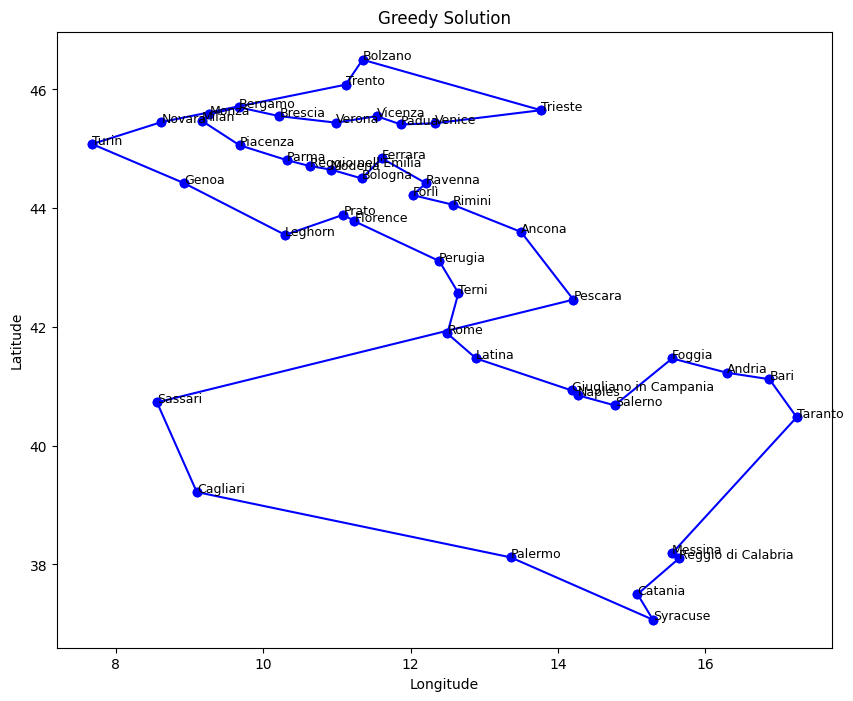

Optimized Path Cost (Simulated Annealing): 4436.03176952516
Simulated Annealing Execution Time: 0.0433 seconds


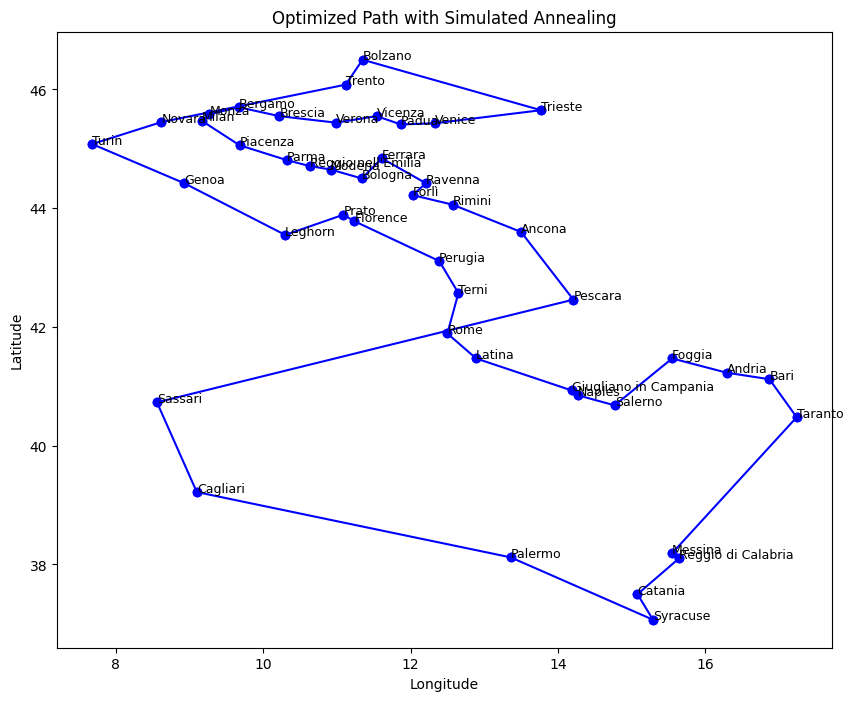

Best Path Cost (Genetic Algorithm): 9470.66003656319
Genetic Algorithm Execution Time: 1.1837 seconds


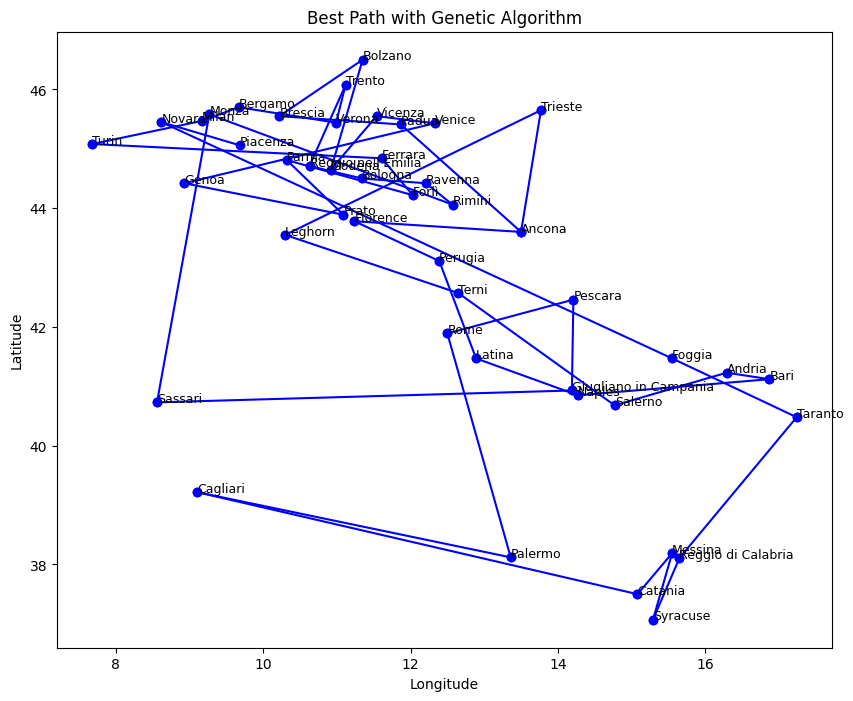


# Confronto dei Risultati

| Algoritmo             | Costo del Percorso (km) | Tempo di Esecuzione (s) |
|-----------------------|-------------------------|--------------------------|
| Greedy                | 4436.03      | 0.0000        |
| Simulated Annealing   | 4436.03    | 0.0433 |
| Algoritmo Genetico    | 9470.66         | 1.1837   |


In [108]:
import time

# Load Data
distance_matrix, cities, n_cities = load_and_distance_matrix('cities/italy.csv')

# Run Greedy Algorithm
start_time = time.time()
initial_path, initial_cost = greedy_algorithm(distance_matrix, start_city=0)
greedy_time = time.time() - start_time
print(f"Greedy Initial Path Cost: {initial_cost}")
print(f"Greedy Execution Time: {greedy_time:.4f} seconds")
plot_path(initial_path, cities, title="Greedy Solution")

# Simulated Annealing Optimization
start_time = time.time()
optimized_path, optimized_cost = simulated_annealing(initial_path, distance_matrix)
simulated_annealing_time = time.time() - start_time
print(f"Optimized Path Cost (Simulated Annealing): {optimized_cost}")
print(f"Simulated Annealing Execution Time: {simulated_annealing_time:.4f} seconds")
plot_path(optimized_path, cities, title="Optimized Path with Simulated Annealing")

# Genetic Algorithm Execution
start_time = time.time()
best_path, best_cost = genetic_algorithm(distance_matrix)
genetic_algorithm_time = time.time() - start_time
print(f"Best Path Cost (Genetic Algorithm): {best_cost}")
print(f"Genetic Algorithm Execution Time: {genetic_algorithm_time:.4f} seconds")
plot_path(best_path, cities, title="Best Path with Genetic Algorithm")

# Display the results in a markdown table
display(Markdown(f"""
# Confronto dei Risultati

| Algoritmo             | Costo del Percorso (km) | Tempo di Esecuzione (s) |
|-----------------------|-------------------------|--------------------------|
| Greedy                | {initial_cost:.2f}      | {greedy_time:.4f}        |
| Simulated Annealing   | {optimized_cost:.2f}    | {simulated_annealing_time:.4f} |
| Algoritmo Genetico    | {best_cost:.2f}         | {genetic_algorithm_time:.4f}   |
"""))


Greedy Initial Path Cost: 63962.9184294552
Greedy Execution Time: 0.1683 seconds


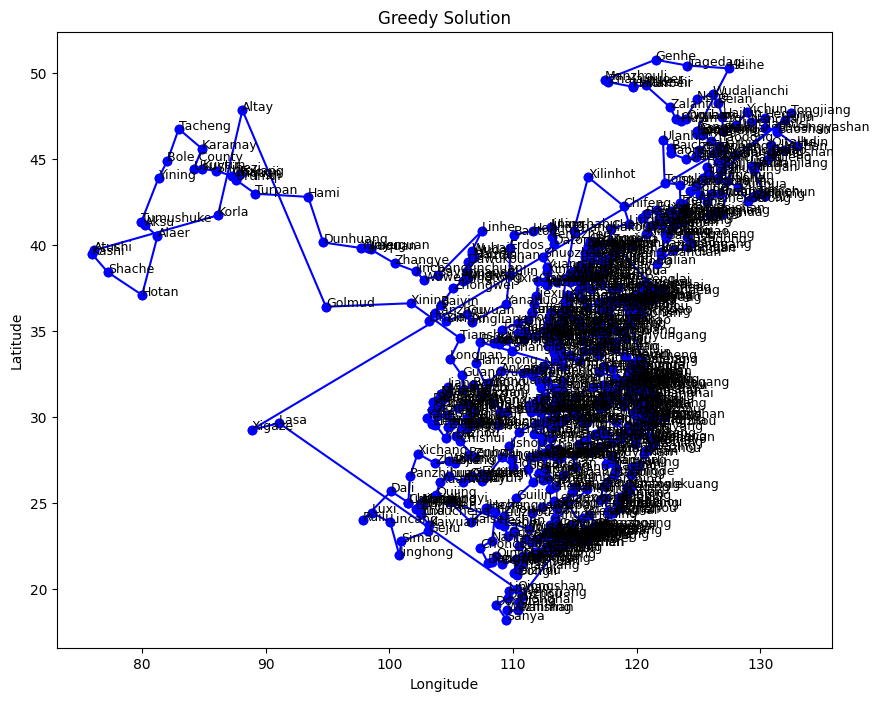

Optimized Path Cost (Simulated Annealing): 63962.9184294552
Simulated Annealing Execution Time: 0.5668 seconds


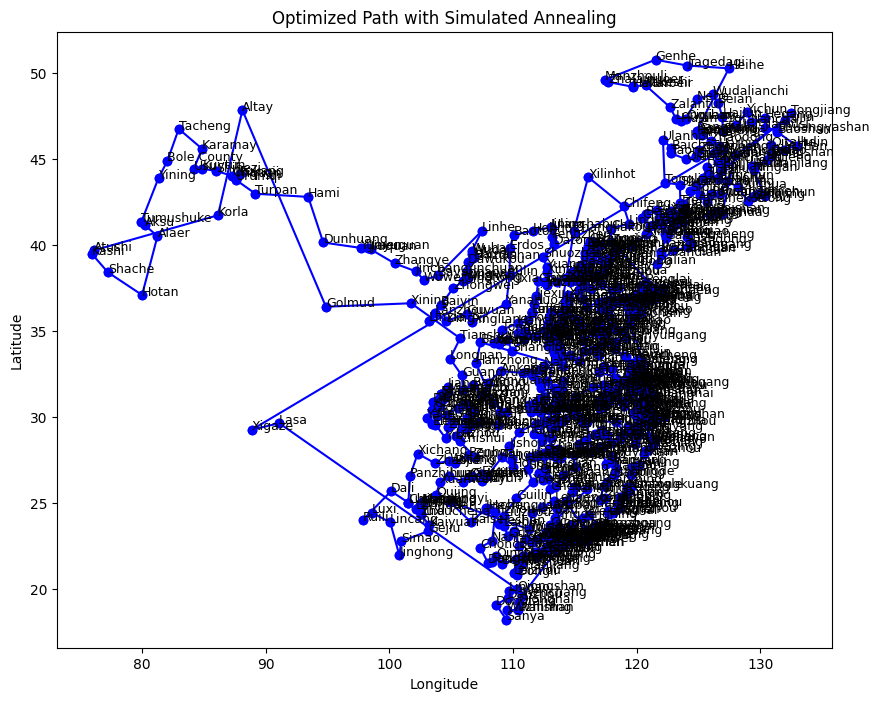

Best Path Cost (Genetic Algorithm): 605904.5020192116
Genetic Algorithm Execution Time: 17.2810 seconds


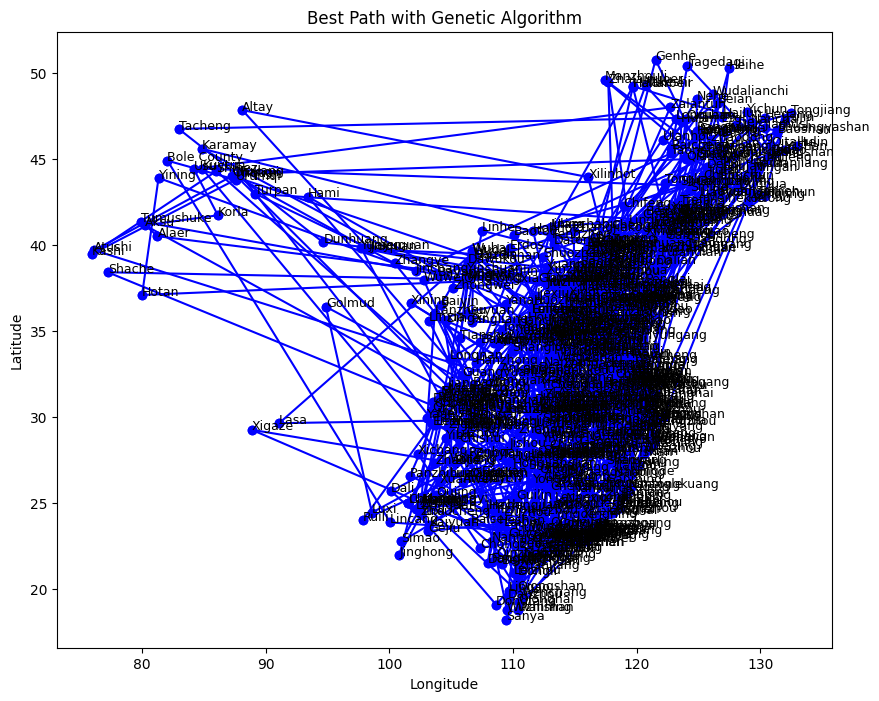


# Confronto dei Risultati

| Algoritmo             | Costo del Percorso (km) | Tempo di Esecuzione (s) |
|-----------------------|-------------------------|--------------------------|
| Greedy                | 63962.92      | 0.1683        |
| Simulated Annealing   | 63962.92    | 0.5668 |
| Algoritmo Genetico    | 605904.50         | 17.2810   |


In [109]:
import time

# Load Data
distance_matrix, cities, n_cities = load_and_distance_matrix('cities/china.csv')

# Run Greedy Algorithm
start_time = time.time()
initial_path, initial_cost = greedy_algorithm(distance_matrix, start_city=0)
greedy_time = time.time() - start_time
print(f"Greedy Initial Path Cost: {initial_cost}")
print(f"Greedy Execution Time: {greedy_time:.4f} seconds")
plot_path(initial_path, cities, title="Greedy Solution")

# Simulated Annealing Optimization
start_time = time.time()
optimized_path, optimized_cost = simulated_annealing(initial_path, distance_matrix)
simulated_annealing_time = time.time() - start_time
print(f"Optimized Path Cost (Simulated Annealing): {optimized_cost}")
print(f"Simulated Annealing Execution Time: {simulated_annealing_time:.4f} seconds")
plot_path(optimized_path, cities, title="Optimized Path with Simulated Annealing")

# Genetic Algorithm Execution
start_time = time.time()
best_path, best_cost = genetic_algorithm(distance_matrix)
genetic_algorithm_time = time.time() - start_time
print(f"Best Path Cost (Genetic Algorithm): {best_cost}")
print(f"Genetic Algorithm Execution Time: {genetic_algorithm_time:.4f} seconds")
plot_path(best_path, cities, title="Best Path with Genetic Algorithm")

# Display the results in a markdown table
display(Markdown(f"""
# Confronto dei Risultati

| Algoritmo             | Costo del Percorso (km) | Tempo di Esecuzione (s) |
|-----------------------|-------------------------|--------------------------|
| Greedy                | {initial_cost:.2f}      | {greedy_time:.4f}        |
| Simulated Annealing   | {optimized_cost:.2f}    | {simulated_annealing_time:.4f} |
| Algoritmo Genetico    | {best_cost:.2f}         | {genetic_algorithm_time:.4f}   |
"""))


Greedy Initial Path Cost: 48050.02586446137
Greedy Execution Time: 0.0270 seconds


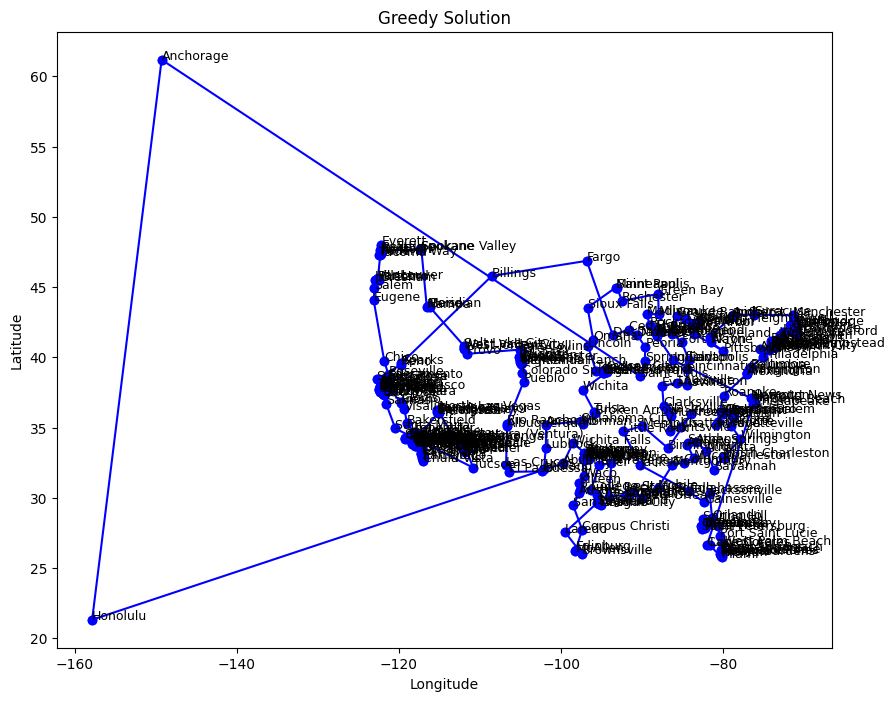

Optimized Path Cost (Simulated Annealing): 48050.02586446137
Simulated Annealing Execution Time: 0.2080 seconds


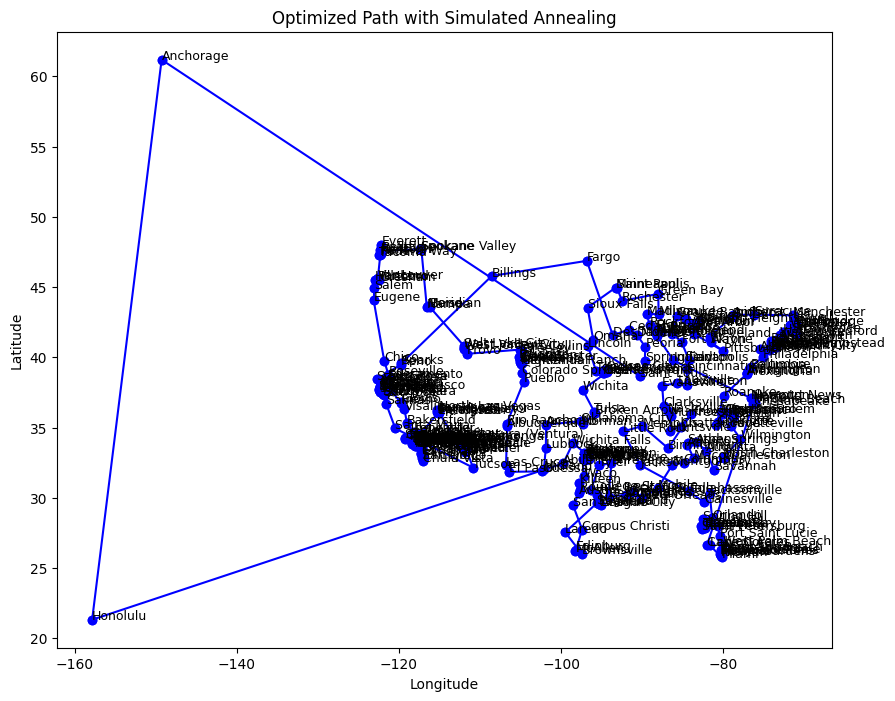

Best Path Cost (Genetic Algorithm): 326099.4094976325
Genetic Algorithm Execution Time: 5.4130 seconds


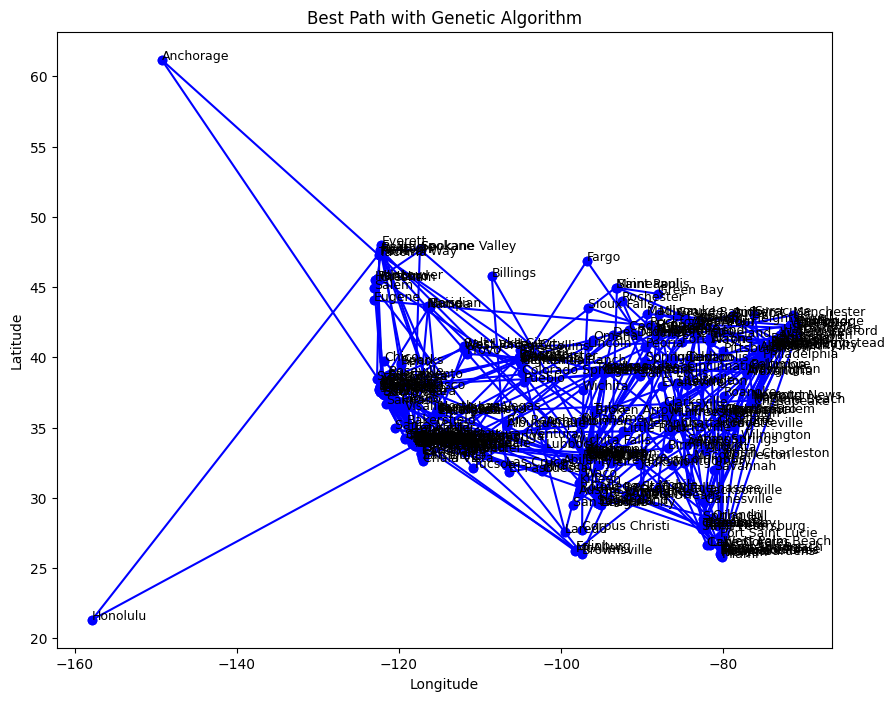


# Confronto dei Risultati

| Algoritmo             | Costo del Percorso (km) | Tempo di Esecuzione (s) |
|-----------------------|-------------------------|--------------------------|
| Greedy                | 48050.03      | 0.0270        |
| Simulated Annealing   | 48050.03    | 0.2080 |
| Algoritmo Genetico    | 326099.41         | 5.4130   |


In [110]:
import time

# Load Data
distance_matrix, cities, n_cities = load_and_distance_matrix('cities/us.csv')

# Run Greedy Algorithm
start_time = time.time()
initial_path, initial_cost = greedy_algorithm(distance_matrix, start_city=0)
greedy_time = time.time() - start_time
print(f"Greedy Initial Path Cost: {initial_cost}")
print(f"Greedy Execution Time: {greedy_time:.4f} seconds")
plot_path(initial_path, cities, title="Greedy Solution")

# Simulated Annealing Optimization
start_time = time.time()
optimized_path, optimized_cost = simulated_annealing(initial_path, distance_matrix)
simulated_annealing_time = time.time() - start_time
print(f"Optimized Path Cost (Simulated Annealing): {optimized_cost}")
print(f"Simulated Annealing Execution Time: {simulated_annealing_time:.4f} seconds")
plot_path(optimized_path, cities, title="Optimized Path with Simulated Annealing")

# Genetic Algorithm Execution
start_time = time.time()
best_path, best_cost = genetic_algorithm(distance_matrix)
genetic_algorithm_time = time.time() - start_time
print(f"Best Path Cost (Genetic Algorithm): {best_cost}")
print(f"Genetic Algorithm Execution Time: {genetic_algorithm_time:.4f} seconds")
plot_path(best_path, cities, title="Best Path with Genetic Algorithm")

# Display the results in a markdown table
display(Markdown(f"""
# Confronto dei Risultati

| Algoritmo             | Costo del Percorso (km) | Tempo di Esecuzione (s) |
|-----------------------|-------------------------|--------------------------|
| Greedy                | {initial_cost:.2f}      | {greedy_time:.4f}        |
| Simulated Annealing   | {optimized_cost:.2f}    | {simulated_annealing_time:.4f} |
| Algoritmo Genetico    | {best_cost:.2f}         | {genetic_algorithm_time:.4f}   |
"""))
